In [1]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [2]:
!sudo apt install tesseract-ocr
!pip install pytesseract




tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 68 not upgraded.


In [3]:
import numpy as np
import pandas as pd
import requests
import concurrent.futures
import re
import torch
import timm
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm,trange,tqdm_notebook
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import time
import copy
from collections import defaultdict
import gc
from io import BytesIO
import pickle
from transformers import BertTokenizer, BertModel
import pytesseract
device = 'cuda' if torch.cuda.is_available() else 'cpu'

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
train = pd.read_csv('/kaggle/input/adobe-task1-train/behaviour_simulation_train.csv')

In [5]:
def extract_preview_link(media_str):
    gif_match = re.search(r"Gif\(thumbnailUrl='(.*?)'", media_str)
    photo_match = re.search(r"Photo\(previewUrl='(.*?)'", media_str)
    video_match = re.search(r"Video\(thumbnailUrl='(.*?)'", media_str)

    if gif_match:
        return gif_match.group(1)
    elif photo_match:
        return photo_match.group(1)
    elif video_match:
        return video_match.group(1)
    else:
        return None
    
train.loc[:, 'preview_link'] = train['media'].apply(extract_preview_link)

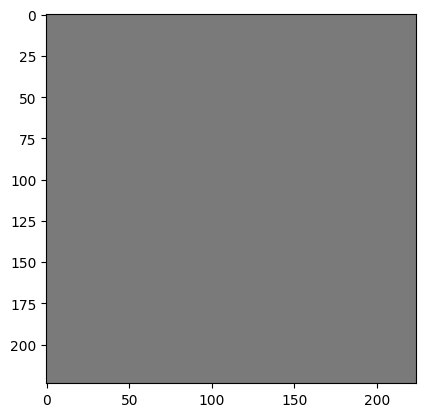

In [6]:
def get_placeholder_image(size=(224, 224), color=(122, 122, 122)):
    return np.array(Image.new("RGB", size, color))
default_image = get_placeholder_image()
plt.imshow(default_image)

In [7]:
class Adobe_Dataset_train(Dataset):
    def __init__(self, train, default_im, transform=None, bert_model=None, tokenizer=None):
        self.train = train
        self.default_image = default_im
        self.transform = transform
        self.bert_model = bert_model
        self.tokenizer = tokenizer

    def __len__(self):
        return self.train.shape[0]

    def get_image_from_url(self, url):
        try:
            response = requests.get(url, timeout=5)
            if response.status_code == 200:
                img = np.array(Image.open(BytesIO(response.content)).convert('RGB'))
                return img
            else:
                return self.default_image
        except requests.RequestException:
            return self.default_image

    def extract_ocr_text(self, img):
        return pytesseract.image_to_string(img)

    def get_bert_embedding(self, text):
        inputs = self.tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding=True).to(device)
        with torch.no_grad():
            outputs = self.bert_model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze().detach().cpu()

    def __getitem__(self, idx):
        img = self.get_image_from_url(self.train['preview_link'][idx])
        target = self.train['likes'][idx]

        ocr_text = self.extract_ocr_text(img)
        metadata_text = self.train['content'][idx]

        ocr_embedding = self.get_bert_embedding(ocr_text)
        metadata_embedding = self.get_bert_embedding(metadata_text)

        if self.transform:
            img = self.transform(image=img)['image']

        return [img, ocr_embedding, metadata_embedding, target]

class Adobe_Dataset_val(Adobe_Dataset_train):
    def __init__(self, val, default_im, transform=None, bert_model=None, tokenizer=None):
        super().__init__(val, default_im, transform, bert_model, tokenizer)

In [8]:
# class Adobe_Dataset_train(Dataset):
#     def __init__(self,train,default_im,transform=None):
#         self.train = train
#         self.default_image = default_im
#         self.transform = transform
#     def __len__(self):
#         return self.train.shape[0]
#     def get_image_from_url(self, url):
#         try:
#             response = requests.get(url, timeout=5)
#             if response.status_code == 200:
#                 img = np.array(Image.open(BytesIO(response.content)).convert('RGB'))
#                 return img
#             else:
#                 return self.default_image
#         except requests.RequestException:
#             return self.default_image
#     def __getitem__(self,idx):
#         img = self.get_image_from_url(self.train['preview_link'][idx])
#         target = self.train['likes'][idx]

#         if self.transform:
#             img = self.transform(image=img)['image']
#         return [img,target]

In [9]:
# class Adobe_Dataset_val(Dataset):
#     def __init__(self,val,default_im,transform=None):
#         self.val = val
#         self.default_image = default_im
#         self.transform = transform

#     def __len__(self):
#         return self.val.shape[0]

#     def get_image_from_url(self, url):
#         try:
#             response = requests.get(url, timeout=5)
#             if response.status_code == 200:
#                 img = np.array(Image.open(BytesIO(response.content)).convert('RGB'))
#                 return img
#             else:
#                 return self.default_image
#         except requests.RequestException:
#             return self.default_image

#     def __getitem__(self,idx):
#         img = self.get_image_from_url(self.val['preview_link'][idx])
#         target = self.val['likes'][idx]
#         if self.transform:
#             img = self.transform(image=img)['image']
#         return [img,target]

In [10]:
# scaler = MinMaxScaler()
# y=np.array(train['likes'])
# train['likes']=scaler.fit_transform(y.reshape(-1,1))
eps = 5
train['likes']=np.log(train['likes']+eps)

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [12]:
transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])
train_set = train[:2000]
val_set = train[2000:3000].reset_index()
# train_dataset = Adobe_Dataset_train(train_set,default_im,transform)
# val_dataset = Adobe_Dataset_val(val_set,default_im,transform)
# train_loader = DataLoader(train_dataset, batch_size = 64
# val_loader = DataLoader(val_dataset, batch_size = 32)

In [13]:
train_dataset = Adobe_Dataset_train(train_set, default_image, transform=transform, bert_model=bert_model, tokenizer=tokenizer)
val_dataset = Adobe_Dataset_val(val_set, default_image, transform=transform, bert_model=bert_model, tokenizer=tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False,num_workers=0)

(<matplotlib.image.AxesImage at 0x7c74260fa1a0>,
 tensor([[-0.0092, -0.2219, -0.3448,  ..., -0.1524, -0.5097, -0.0513],
         [-0.0092, -0.2219, -0.3448,  ..., -0.1524, -0.5097, -0.0513],
         [-0.0092, -0.2219, -0.3448,  ..., -0.1524, -0.5097, -0.0513],
         ...,
         [ 0.0608, -0.0183,  0.5047,  ..., -0.3054, -0.1018,  0.6388],
         [-0.0092, -0.2219, -0.3448,  ..., -0.1524, -0.5097, -0.0513],
         [-0.0092, -0.2219, -0.3448,  ..., -0.1524, -0.5097, -0.0513]]))

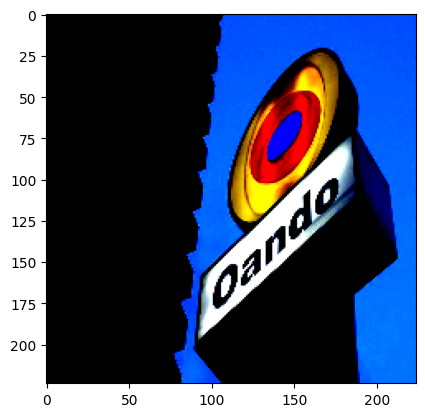

In [14]:
l = next(iter(val_loader))
plt.imshow(l[0][0].permute(1,2,0)),l[1]

In [15]:
def acc_metric(y_true,y_pred):
    return r2_score(y_true.detach().cpu().numpy(),y_pred.detach().cpu().numpy())

In [16]:
# class Img_Model(nn.Module):
#     def __init__(self,out_features=1):
#         super().__init__()
#         self.model = timm.create_model('efficientnet_b0',pretrained=True)
#         in_features = self.model.classifier.in_features
#         self.model.classifier = nn.Sequential(nn.Linear(in_features,512),
#                                               nn.Linear(512,1))
#     def forward(self,x):
#         return self.model(x)
# model = Img_Model().to(device)

In [17]:
class CombinedModel(nn.Module):
    def __init__(self, out_features=1):
        super().__init__()
        # Image model
        self.cnn_model = timm.create_model('efficientnet_b0', pretrained=True)
        in_features = self.cnn_model.classifier.in_features
        self.cnn_model.classifier = nn.Identity()

        self.fc1 = nn.Linear(in_features + 768*2, 512)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, out_features)

    def forward(self, img, ocr_embed, metadata_embed):
        img_features = self.cnn_model(img)
        combined_features = torch.cat((img_features, ocr_embed, metadata_embed), dim=1)
        x = self.dropout(self.fc1(combined_features))
        x = self.fc2(x)
        return x

model = CombinedModel().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=2,gamma=0.1)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [18]:
# def train_one_epoch(model, optimizer, scheduler, device, dataloader, epoch):
#     model.train()
#     dataset_size = 0
#     running_loss = 0.0
#     running_mse  = 0.0
#     bar = tqdm(enumerate(dataloader), total=len(dataloader))
#     y_true = []
#     y_pred = []

#     for step, data in bar:
#         images = data[0].to(device, dtype=torch.float)
#         targets = data[1].to(device, dtype=torch.float)
#         batch_size = images.size(0)

#         optimizer.zero_grad()

#         outputs = model(images).squeeze()
#         loss = loss_fn(outputs, targets)

#         loss.backward()
#         optimizer.step()

#         running_loss += (loss.item() * batch_size)
#         running_mse += ((outputs - targets) ** 2).sum().item()

#         dataset_size += batch_size

#         epoch_loss = running_loss / dataset_size
#         epoch_mse = running_mse / dataset_size

#         y_pred.append(outputs.detach())
#         y_true.append(targets.detach())

#         bar.set_postfix(Epoch=epoch, Loss=epoch_loss, MSE=epoch_mse)

#     y_pred = torch.cat(y_pred, dim=0)
#     y_true = torch.cat(y_true, dim=0)

#     epoch_r2 = acc_metric(y_true, y_pred)

#     print(f'Epoch = {epoch}, Train_Loss = {epoch_loss}, Train_R² = {epoch_r2}, LR = {optimizer.param_groups[0]["lr"]}')

#     gc.collect()
#     torch.cuda.empty_cache()

#     return epoch_loss, epoch_r2

In [19]:
# def valid_one_epoch(model, dataloader, device, epoch):
#     model.eval()
#     dataset_size = 0
#     running_loss = 0.0
#     running_mse = 0.0
#     with torch.inference_mode():
#         y_pred = []
#         y_true = []
#         bar = tqdm(enumerate(dataloader), total=len(dataloader))
#         for step, data in bar:
#             images = data[0].to(device, dtype=torch.float)
#             targets = data[1].to(device, dtype=torch.float)
#             batch_size = images.size(0)
#             outputs = model(images).squeeze()
#             y_pred.append(outputs)
#             y_true.append(targets)
#             loss = loss_fn(outputs, targets)
#             running_loss += (loss.item() * batch_size)
#             dataset_size += batch_size
#             epoch_loss = running_loss / dataset_size
#             epoch_mse = running_mse / dataset_size
#             del images
#             del targets
#             del batch_size
#         y_pred = torch.cat(y_pred, dim = 0)
#         y_true = torch.cat(y_true, dim = 0)
#         epoch_r2 = acc_metric(y_true,y_pred)
#         print(f'Epoch = {epoch}, Valid_Loss = {epoch_loss}, Valid_r2 = {epoch_r2}, LR = {optimizer.param_groups[0]["lr"]}')
#     torch.cuda.empty_cache()
#     gc.collect()
#     return epoch_loss, epoch_r2

In [20]:
def train_one_epoch(model, optimizer, scheduler, device, dataloader, epoch):
    model.train()
    dataset_size = 0
    running_loss = 0.0
    running_mse  = 0.0
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    y_true = []
    y_pred = []

    for step, data in bar:
        images = data[0].to(device, dtype=torch.float)
        bert_embed_content = data[1].to(device, dtype=torch.float)
        bert_embed_ocr = data[2].to(device, dtype=torch.float)
        targets = data[3].to(device, dtype=torch.float)
        batch_size = images.size(0)

        optimizer.zero_grad()

        outputs = model(images, bert_embed_content, bert_embed_ocr).squeeze()
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += (loss.item() * batch_size)
        running_mse += ((outputs - targets) ** 2).sum().item()


        dataset_size += batch_size
        epoch_loss = running_loss / dataset_size
        epoch_mse = running_mse / dataset_size

        y_pred.append(outputs.detach())
        y_true.append(targets.detach())

        bar.set_postfix(Epoch=epoch, Loss=epoch_loss)

    y_pred = torch.cat(y_pred, dim=0)
    y_true = torch.cat(y_true, dim=0)

    epoch_r2 = acc_metric(y_true, y_pred)

    print(f'Epoch = {epoch}, Train_Loss = {epoch_loss}, Train_R2 = {epoch_r2}, LR = {optimizer.param_groups[0]["lr"]}')

    gc.collect()
    torch.cuda.empty_cache()

    return epoch_loss, epoch_r2

In [21]:
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    running_mse = 0.0
    with torch.inference_mode():
        y_pred = []
        y_true = []
        bar = tqdm(enumerate(dataloader), total=len(dataloader))
        for step, data in bar:
            images = data[0].to(device, dtype=torch.float)
            bert_embed_content = data[1].to(device, dtype=torch.float)
            bert_embed_ocr = data[2].to(device, dtype=torch.float)
            targets = data[3].to(device, dtype=torch.float)
            batch_size = images.size(0)

            outputs = model(images, bert_embed_content, bert_embed_ocr).squeeze()
            y_pred.append(outputs)
            y_true.append(targets)

            loss = loss_fn(outputs, targets)
            running_loss += (loss.item() * batch_size)
            running_mse += ((outputs - targets) ** 2).sum().item()
            dataset_size += batch_size
            epoch_loss = running_loss / dataset_size
            epoch_mse = running_mse / dataset_size

        y_pred = torch.cat(y_pred, dim=0)
        y_true = torch.cat(y_true, dim=0)

        epoch_r2 = acc_metric(y_true, y_pred)

        print(f'Epoch = {epoch}, Valid_Loss = {epoch_loss}, Valid_r2 = {epoch_r2}, LR = {optimizer.param_groups[0]["lr"]}')

    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss, epoch_r2

In [22]:
def run_training(model, optimizer, scheduler, device, train_loader, val_loader, num_epochs):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))

    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_r2 = -np.inf
    history = defaultdict(list)

    for epoch in range(1, num_epochs + 1):
        gc.collect()

        train_epoch_loss, train_epoch_r2 = train_one_epoch(model, optimizer, scheduler, device,
                                           dataloader=train_loader, epoch=epoch)

        val_epoch_loss, val_epoch_r2 = valid_one_epoch(model, val_loader, device, epoch=epoch)
        torch.cuda.empty_cache()

        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train r2'].append(train_epoch_r2)
        history['Valid r2'].append(val_epoch_r2)
        
        if best_epoch_r2 <= val_epoch_r2:
            print(f"Validation R² Improved ({best_epoch_r2:.4f} ---> {val_epoch_r2:.4f})")
            best_epoch_r2 = val_epoch_r2
            best_model_wts = copy.deepcopy(model.state_dict())

            PATH = "R2_{:.4f}_Loss_{:.4f}_Epoch_{:.0f}.pth".format(val_epoch_r2, val_epoch_loss, epoch)
            torch.save(model.state_dict(), PATH)
            print(f"Model saved at: {PATH}")

        print()

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best R²: {:.4f}".format(best_epoch_r2))

    model.load_state_dict(best_model_wts)

    return model, history

In [23]:
model, history = run_training(model, optimizer, scheduler,
                              device,train_loader,val_loader,num_epochs=6)

[INFO] Using GPU: Tesla P100-PCIE-16GB



  4%|▍         | 5/125 [00:33<13:26,  6.72s/it, Epoch=1, Loss=8.81]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 125/125 [13:08<00:00,  6.31s/it, Epoch=1, Loss=4.31]


Epoch = 1, Train_Loss = 4.308697041511536, Train_R2 = 0.049920481129319794, LR = 0.001


100%|██████████| 63/63 [06:24<00:00,  6.10s/it]


Epoch = 1, Valid_Loss = 3.3849579277038573, Valid_r2 = 0.26036832629728635, LR = 0.001
Validation R² Improved (-inf ---> 0.2604)
Model saved at: R2_0.2604_Loss_3.3850_Epoch_1.pth



 31%|███       | 39/125 [04:11<09:02,  6.30s/it, Epoch=2, Loss=3.17]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 125/125 [13:06<00:00,  6.29s/it, Epoch=2, Loss=3.19]


Epoch = 2, Train_Loss = 3.1885150775909423, Train_R2 = 0.2969236820616332, LR = 0.001


100%|██████████| 63/63 [06:26<00:00,  6.13s/it]


Epoch = 2, Valid_Loss = 3.680029706954956, Valid_r2 = 0.19589353768421924, LR = 0.001



 79%|███████▉  | 99/125 [10:19<02:40,  6.17s/it, Epoch=3, Loss=2.72]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 125/125 [13:04<00:00,  6.27s/it, Epoch=3, Loss=2.7]


Epoch = 3, Train_Loss = 2.702144036769867, Train_R2 = 0.4041698260341866, LR = 0.001


100%|██████████| 63/63 [06:25<00:00,  6.12s/it]


Epoch = 3, Valid_Loss = 3.3925568294525146, Valid_r2 = 0.2587079180582026, LR = 0.001



 21%|██        | 26/125 [02:52<10:36,  6.43s/it, Epoch=4, Loss=2.82]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 125/125 [13:13<00:00,  6.35s/it, Epoch=4, Loss=2.58]


Epoch = 4, Train_Loss = 2.581417270183563, Train_R2 = 0.4307904055910168, LR = 0.001


100%|██████████| 63/63 [06:23<00:00,  6.09s/it]


Epoch = 4, Valid_Loss = 3.2971241550445556, Valid_r2 = 0.27956047851203836, LR = 0.001
Validation R² Improved (0.2604 ---> 0.2796)
Model saved at: R2_0.2796_Loss_3.2971_Epoch_4.pth



 19%|█▉        | 24/125 [02:26<10:01,  5.96s/it, Epoch=5, Loss=2.05]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 125/125 [13:05<00:00,  6.29s/it, Epoch=5, Loss=2.26]


Epoch = 5, Train_Loss = 2.260826319217682, Train_R2 = 0.5014815953224414, LR = 0.001


100%|██████████| 63/63 [06:22<00:00,  6.08s/it]


Epoch = 5, Valid_Loss = 3.4121878509521486, Valid_r2 = 0.25441843766599503, LR = 0.001



 85%|████████▍ | 106/125 [11:13<01:55,  6.06s/it, Epoch=6, Loss=1.92]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 125/125 [13:07<00:00,  6.30s/it, Epoch=6, Loss=1.91]


Epoch = 6, Train_Loss = 1.911954179763794, Train_R2 = 0.5784088588727498, LR = 0.001


100%|██████████| 63/63 [06:24<00:00,  6.10s/it]


Epoch = 6, Valid_Loss = 3.5128066883087157, Valid_r2 = 0.23243267224457187, LR = 0.001

Training complete in 1h 57m 18s
Best R²: 0.2796


In [24]:
PATH = 'final_model.pkl'
with open(PATH, 'wb') as f:
    pickle.dump(model, f)
PATH_2 = 'history.pkl'
with open(PATH_2, 'wb') as f:
    pickle.dump(history, f)